In [1]:
import sys
sys.path.insert(0, '../')
import os
import numpy as np
import gzip
import json
import pickle
import glob
import torch
from torchvision.ops import box_iou
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import vq2d.data
from detectron2.data import get_detection_dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
# from detectron2_extensions.config import get_cfg as get_detectron_cfg

In [2]:
gt_data_path = "../data/val_annot.json"
with open(gt_data_path, "r") as f:
    gt_data = json.load(f)

In [3]:
duid2gt = {a['dataset_uid']: a for a in gt_data}

In [29]:
det_files = sorted(glob.glob("/work/prannay/ego4d/ckpt/rpn_run_coco_pretrained/inference_vq2d_val_pos_frame/box_proposals_*_0000002.pkl"))

In [30]:
det_files

['/work/prannay/ego4d/ckpt/rpn_run_coco_pretrained/inference_vq2d_val_pos_frame/box_proposals_0000000_0000002.pkl',
 '/work/prannay/ego4d/ckpt/rpn_run_coco_pretrained/inference_vq2d_val_pos_frame/box_proposals_0000001_0000002.pkl']

In [31]:
rpn_results = {
    "boxes": [],
    "objectness_logits": [],
    "ids": [],
    "bbox_mode": 0,
}

In [32]:
rpn_results = defaultdict(list)
for det_file in det_files:
    with open(det_file, "rb") as f:
        dets = pickle.load(f)
    for k, v in dets.items():
        if k != "bbox_mode":
            rpn_results[k].extend(v)
        else:
            rpn_results[k] = v

In [33]:
with open("../data/val_annot_pos_frame_cocofied.json", "r") as f:
    cocofied_data = json.load(f)


In [34]:
aid2ann = {a['id']: a for a in cocofied_data['annotations']}
iid2img = {a['id']: a for a in cocofied_data['images']}

In [35]:
duid2aid = defaultdict(list)
aid2duid = {}
for img in cocofied_data["images"]:
    duid2aid[img["dataset_uid"]].append(img["id"])
    aid2duid[img["id"]] = img["dataset_uid"]


In [36]:
# [iid2img[iid]['file_name'] for iid in duid2aid['val_0000000000']]

In [37]:
for k, v in duid2aid.items():
    assert (sorted(v) == v)

In [38]:
aid2rpn_predictions = {}
for aid, bbs, scs in zip(rpn_results['ids'], rpn_results['boxes'], rpn_results['objectness_logits']):
    aid2rpn_predictions[aid] = {
        "boxes": bbs,
        "scores": scs,
    }

In [39]:
duid2rpn_predictions = defaultdict(list)
for duid, aids in duid2aid.items():
    for aid in aids:
        duid2rpn_predictions[duid].append(aid2rpn_predictions[aid])

In [40]:
def calculate_intersections(duid2rpn_predictions, duid2gt):
    duid2intersections = defaultdict(list)
    duid2scores = defaultdict(list)
    for duid, rpn_predictions in tqdm(duid2rpn_predictions.items(), total=len(duid2rpn_predictions)):
        gt = duid2gt[duid]
        gt_boxes = gt['response_track']
        assert len(gt_boxes) == len(rpn_predictions)
        # print(duid)
        for gt_box, rpn_pred in zip(gt_boxes, rpn_predictions):
            gt_box = [gt_box['x'], gt_box['y'], gt_box['x'] + gt_box['width'], gt_box['y'] + gt_box['height']]
            gt_box = torch.tensor(gt_box).unsqueeze(0)
            rpn_boxes = torch.from_numpy(rpn_pred['boxes'])
            assert rpn_boxes.size(0) == 1000
            ious = box_iou(gt_box, rpn_boxes)
            duid2intersections[duid].append(ious[0].numpy())
            duid2scores[duid].append(rpn_pred['scores'])
        # print(gt_boxes[0])
        # print(gt_boxes[-1])
        # print(rpn_predictions[0])
        # print(rpn_predictions[-1])
        # break
        # gt_boxes = [[gt_box['x'], gt_box['y'], gt_box['x'] + gt_box['width'], gt_box['y'] + gt_box['height']] for gt_box in gt_boxes]
        # gt_boxes = torch.tensor(gt_boxes)
        # rpn_boxes = torch.tensor(rpn_predictions['boxes'])
        # ious = box_iou(gt_boxes, rpn_boxes)
        # duid2intersections[duid] = ious[0].numpy()
    return duid2intersections, duid2scores

In [41]:
duid2intersections, duid2scores = calculate_intersections(duid2rpn_predictions, duid2gt)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [42]:
def calculate_recall_per_video(duid2intersections, threshold=0.5, k=1000):
    duid2recall = {}
    for duid, intersections in duid2intersections.items():
        recall = []
        for intersection in intersections:
            recall.append(np.max(intersection[:k]) > threshold)
        duid2recall[duid] = recall
    return duid2recall

In [43]:
# duid2recall = calculate_recall_per_video(duid2intersections, threshold=0.5, k=20)

In [44]:
def calculate_recall_videowise(duid2recall):
    recall_per_video = []
    for duid, recall in duid2recall.items():
        recall_per_video.append(np.max(recall))
    return np.mean(recall_per_video)

In [45]:
def calculate_recall_framewise(duid2recall):
    recall_per_frame = []
    for duid, recall in duid2recall.items():
        recall_per_frame.extend(recall)
    return np.mean(recall_per_frame)

In [46]:
iou_thresholds = [0.3, 0.5, 0.75]
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
recalls_video = np.zeros((len(iou_thresholds), len(ks)))
recalls_frame = np.zeros((len(iou_thresholds), len(ks)))
for i, iou in enumerate(iou_thresholds):
    for j, k in enumerate(ks):
        duid2recall = calculate_recall_per_video(duid2intersections, threshold=iou, k=k)
        recall_v = calculate_recall_videowise(duid2recall)
        recall_f = calculate_recall_framewise(duid2recall)
        recalls_video[i, j] = recall_v
        recalls_frame[i, j] = recall_f

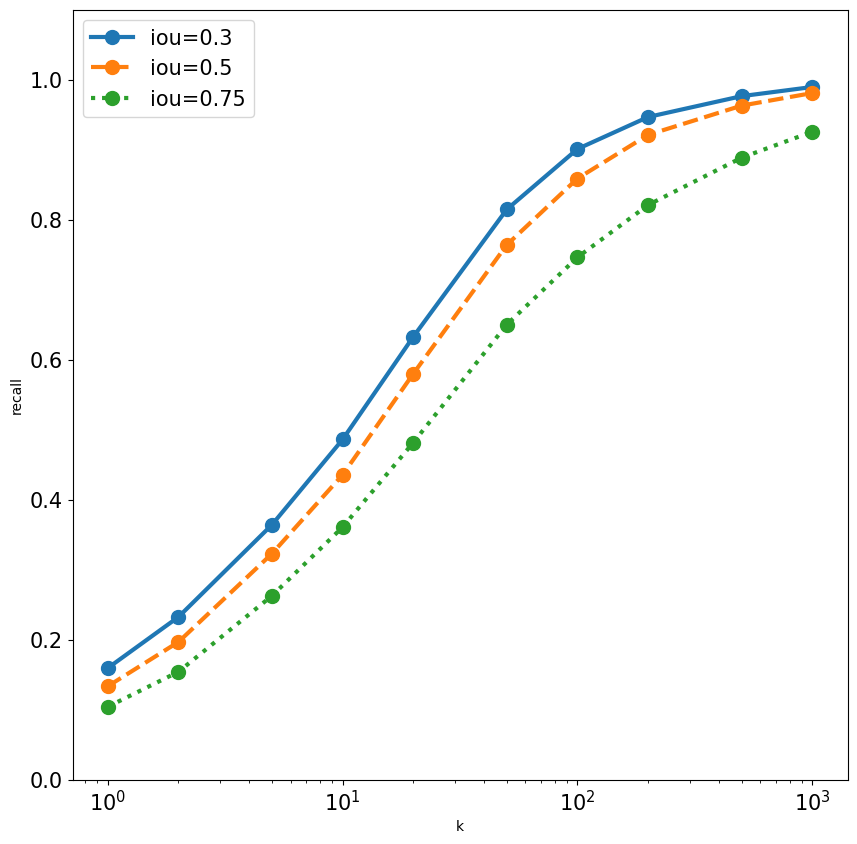

In [47]:
# lets plot the recall vs k for different iou thresholds using log scale for the k axis
# use different line styles for different iou thresholds
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
linestyles = ['-', '--', ':', '-.']
for i, iou in enumerate(iou_thresholds):
    ax.plot(ks, recalls_video[i], label=f"iou={iou}", linestyle=linestyles[i], lw=3, marker='o', markersize=10)
# make text a bit larger
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xscale("log")
ax.set_xlabel("k")
ax.set_ylabel("recall")
# Make legend text a bit larger
ax.legend(prop={'size': 15})
ax.set_ylim(0, 1.1)
plt.show()

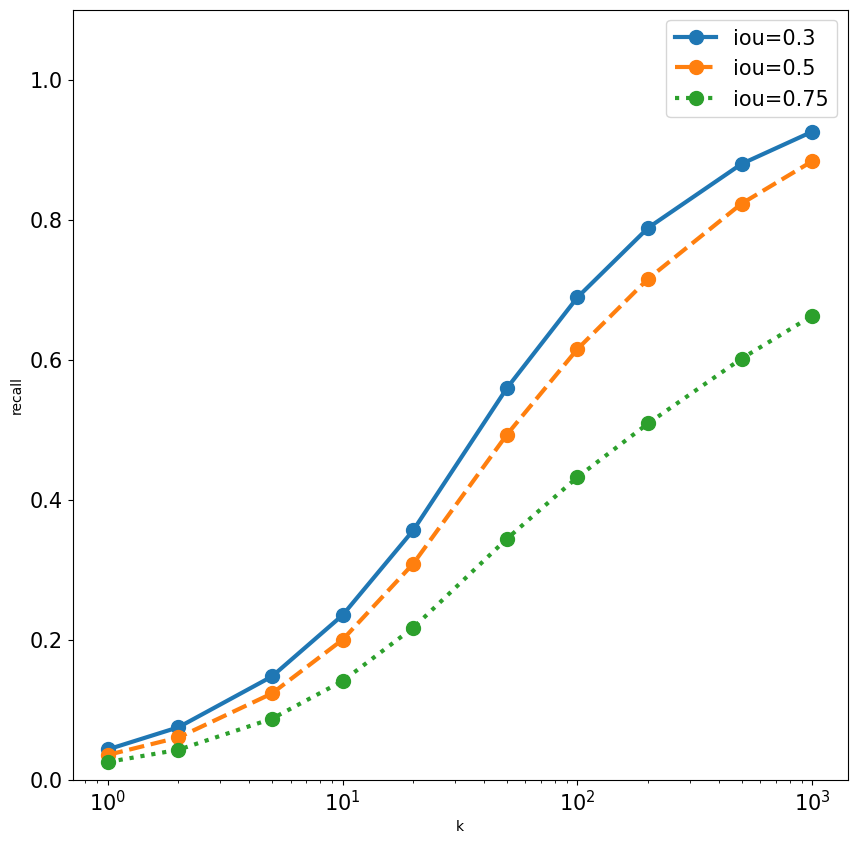

In [48]:
# lets plot the recall vs k for different iou thresholds using log scale for the k axis
# use different line styles for different iou thresholds
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
linestyles = ['-', '--', ':', '-.']
for i, iou in enumerate(iou_thresholds):
    ax.plot(ks, recalls_frame[i], label=f"iou={iou}", linestyle=linestyles[i], lw=3, marker='o', markersize=10)
# make text a bit larger
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xscale("log")
ax.set_xlabel("k")
ax.set_ylabel("recall")
# Make legend text a bit larger
ax.legend(prop={'size': 15})
ax.set_ylim(0, 1.1)
plt.show()

In [7]:
duid2pred = {}
for det_file in tqdm(det_files, total=len(det_files)):
    with gzip.open(det_file, "rt") as f:
        det_data = json.load(f)
    det_data = det_data['predictions']
    # print(det_data.keys())
    for (duid, scs, bbs, vcs, gt_rt) in zip(
            det_data['dataset_uids'],
            det_data['predicted_scores'],
            det_data['predicted_bboxes'],
            det_data['visual_crop'],
            det_data['groundtruth_response_tracks'],
            # det_data['total_frames'],
            # det_data['accessed_frames'],
            # det_data['ground_truth_response_track'],
    ):
        duid2pred[duid] = {
            'dataset_uid': duid,
            'predicted_scores': scs,
            'predicted_bboxes': bbs,
            'visual_crop': vcs,
            # 'total_frames': tot_fr,
            # 'accessed_frames': acc_fr,
            'ground_truth_response_track': gt_rt,
        }

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
lens = []
scores = []
for k, v in duid2pred.items():
    lens.append(len(v['predicted_scores']))
    scores.extend(v['predicted_scores'])
print(np.mean(lens), np.std(lens), np.median(lens), np.min(lens), np.max(lens))
print(np.mean(scores), np.std(scores), np.median(scores), np.min(scores), np.max(scores))


7.617927668071888 7.52105352728515 5.0 1 66
0.6763054803010229 0.2779645631190442 0.7398867905139923 0.00010512076551094651 0.9994206428527832


In [9]:
def calculate_intersection(gt_rt, pred_bbs, pred_scs):
    # print(gt_rt)
    pred_bbs = torch.tensor([[bb['fno'], bb['x1'], bb['y1'], bb['x2'], bb['y2']] for bb in pred_bbs], dtype=torch.float32)
    pred_scs = torch.tensor(pred_scs)
    gt_bbs = torch.tensor([[bb['frame_number'], bb['x'], bb['y'], bb['x'] + bb['width'], bb['y'] + bb['height']] for bb in gt_rt], dtype=torch.float32)

    pred_gt_iou = box_iou(pred_bbs[:, 1:], gt_bbs[:, 1:])
    # set all boxes from different frames to -10.0
    # print(pred_gt_iou)
    pred_gt_iou[pred_bbs[:, 0].unsqueeze(1) != gt_bbs[:, 0].unsqueeze(0)] = -10.0
    # print(pred_gt_iou)
    # find the max iou for each prediction
    max_iou, max_iou_idx = pred_gt_iou.max(dim=1)
    # print(max_iou, max_iou_idx)
    max_iou_scorewise = max_iou[pred_scs.argsort(descending=True)]
    max_iou_timewise = max_iou[pred_bbs[:, 0].argsort(descending=True)]
    return max_iou_scorewise, max_iou_timewise

In [10]:
# duid2pred[duid]['ground_truth_response_track']

In [11]:
results = {}
for k, v in tqdm(duid2pred.items(), total=len(duid2pred)):
    max_iou_scorewise, max_iou_timewise = calculate_intersection(v['ground_truth_response_track'], v['predicted_bboxes'], v['predicted_scores'])
    results[k] = {
        'max_iou_scorewise': max_iou_scorewise.tolist(),
        'max_iou_timewise': max_iou_timewise.tolist(),
    }

  0%|          | 0/4507 [00:00<?, ?it/s]

In [12]:
no_recall_duids = defaultdict(set)
for iou in [0.3, 0.5]:
    for k, v in tqdm(results.items(), total=len(results)):
        if max(v['max_iou_timewise']) < iou:
            no_recall_duids[iou].add(k)



  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

In [13]:
for k, v in no_recall_duids.items():
    print(k, len(v))

0.3 2003
0.5 2194


In [14]:
total_gt_frames = 0
for duid in no_recall_duids[0.5]:
    total_gt_frames += len(duid2pred[duid]['ground_truth_response_track'])
print(total_gt_frames)


24251


In [15]:
gt_data_interest = [a for a in gt_data if a['dataset_uid'] in no_recall_duids[0.5]]

In [40]:
# lets create coco-style annotations from gt_data and save it
coco_gt_data_annotations = []
coco_gt_data_images = []
aid_counter = 1
iid_counter = 1
for i, a in enumerate(gt_data_interest):
    # print(a)
    # print(a.keys())
    if a['clip_uid'] is None:
        continue
    for bb in a['response_track']:
        coco_gt_data_annotations.append({
            'id': aid_counter,
            'image_id': iid_counter,
            'category_id': 1,
            'bbox': [bb['x'], bb['y'], bb['width'], bb['height']],
            'area': bb['width'] * bb['height'],
            'iscrowd': 0,
        })
        path = os.path.join(a['clip_uid'], "frame_{:07d}.png".format(bb['frame_number']+1))
        assert os.path.isfile(os.path.join("/work/prannay/ego4d/images_val", path)), path
        coco_gt_data_images.append({
            'id': iid_counter,
            'width': bb['original_width'],
            'height': bb['original_height'],
            'file_name': path,
            'dataset_uid': a['dataset_uid'],
            'license': 1,
        })
        aid_counter += 1
        iid_counter += 1
coco_gt_data_categories = [{'id': 1, 'name': 'visual_crop'}]
coco_gt_data_info = {'description': 'ego4d'}
coco_gt_data_license = [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/', 'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License'}]
coco_gt_data = {
    'annotations': coco_gt_data_annotations,
    'images': coco_gt_data_images,
    'categories': coco_gt_data_categories,
    'info': coco_gt_data_info,
    'licenses': coco_gt_data_license,
}


In [41]:
len(coco_gt_data['annotations']), len(coco_gt_data['images'])

(24203, 24203)

In [42]:
with open("/work/prannay/ego4d/ckpt/vq_logs/val_annot_pos_frame_cocofied_interest.json", "w") as f:
    json.dump(coco_gt_data, f)

In [16]:
len(gt_data_interest)

2194

In [18]:
# lets write gt_data_interest to a json file with gzip.open(
with gzip.open("/work/prannay/ego4d/ckpt/vq_logs/vq_stats_tester_dec_gt_data_interest.json.gz", "wt") as f:
    json.dump(gt_data_interest, f)

In [17]:
clips2copy = set()
for a in gt_data_interest:
    clips2copy.add(a['clip_uid'])
print(len(clips2copy))
clips2copy = list(clips2copy)

1021


In [71]:
response_tracks_all = []
for a in gt_data:
    if a['clip_uid'] == "d5935c29-1b8d-417d-9bbb-5ebd47e9256d":
        response_tracks_all.extend(a['response_track'])

In [101]:
def plot_frame(rp_item):
    path = "/work/prannay/ego4d/images_val/d5935c29-1b8d-417d-9bbb-5ebd47e9256d/" + "frame_" + str(rp_item['frame_number']+1).zfill(7) + ".png"
    print(os.path.isfile(path))
    print(path)
    image = Image.open(path)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(image)
    ax.add_patch(Rectangle((rp_item['x'], rp_item['y']), rp_item['width'], rp_item['height'], linewidth=10, edgecolor='r', facecolor='none'))
    plt.show()

True
/work/prannay/ego4d/images_val/d5935c29-1b8d-417d-9bbb-5ebd47e9256d/frame_0001734.png


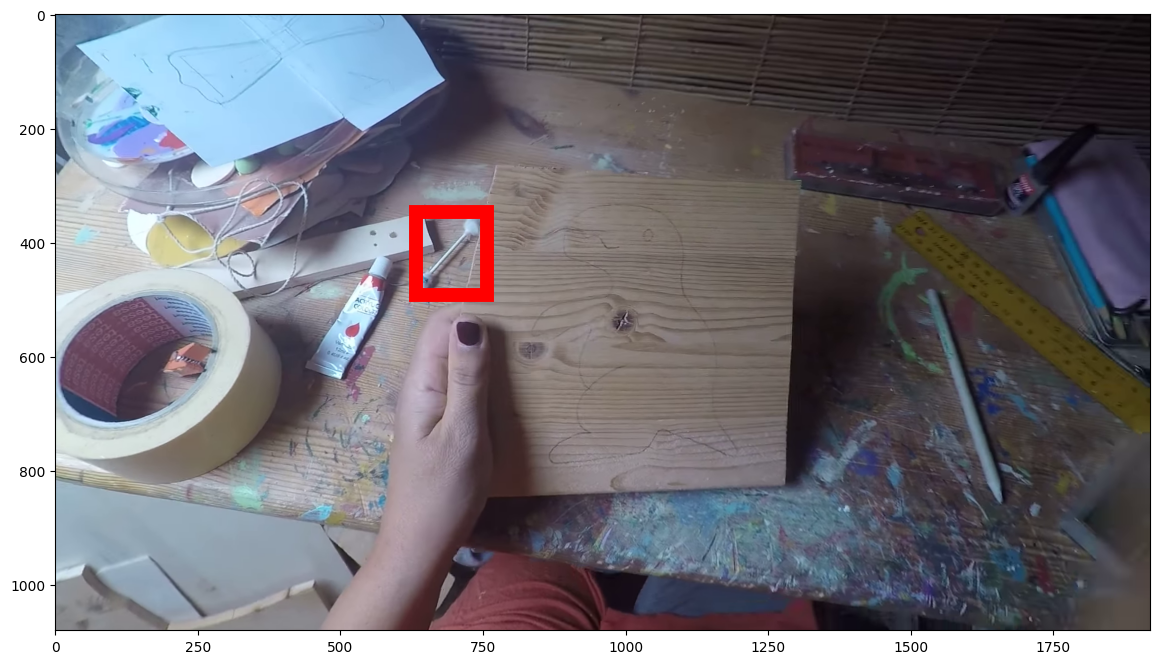

In [109]:
plot_frame(response_tracks_all[-11])

In [69]:
print(gt_data_interest[0]["dataset_uid"])
print(gt_data_interest[0]["clip_uid"])
print(gt_data_interest[0]["response_track"][0])
print(gt_data_interest[0]["response_track"][-1])

val_0000000001
d5935c29-1b8d-417d-9bbb-5ebd47e9256d
{'frame_number': 33, 'x': -0.45, 'y': 975.88, 'width': 84.77, 'height': 95.7, 'rotation': 0, 'original_width': 1920, 'original_height': 1080, 'video_frame_number': 198}
{'frame_number': 58, 'x': 6.15, 'y': 731.38, 'width': 117.26, 'height': 92.13, 'rotation': 0, 'original_width': 1920, 'original_height': 1080, 'video_frame_number': 348}


In [46]:
ious = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
recalls = [1, 2, 3, 5, 10]
for iou in ious:
    for recall in recalls:
        # calculate for scorewise
        recall_s = np.mean([max(a['max_iou_scorewise'][:recall]) >= iou for a in results.values()])
        # calculate for timewise
        recall_t = np.mean([max(a['max_iou_timewise'][:recall]) >= iou for a in results.values()])
        print(f"iou: {iou}, recall: {recall:2d}, scorewise: {recall_s:.3f}, timewise: {recall_t:.3f}")

        

iou: 0.3, recall:  1, scorewise: 0.252, timewise: 0.455
iou: 0.3, recall:  2, scorewise: 0.369, timewise: 0.512
iou: 0.3, recall:  3, scorewise: 0.424, timewise: 0.526
iou: 0.3, recall:  5, scorewise: 0.484, timewise: 0.541
iou: 0.3, recall: 10, scorewise: 0.533, timewise: 0.552
iou: 0.4, recall:  1, scorewise: 0.246, timewise: 0.441
iou: 0.4, recall:  2, scorewise: 0.359, timewise: 0.496
iou: 0.4, recall:  3, scorewise: 0.413, timewise: 0.510
iou: 0.4, recall:  5, scorewise: 0.469, timewise: 0.524
iou: 0.4, recall: 10, scorewise: 0.517, timewise: 0.535
iou: 0.5, recall:  1, scorewise: 0.235, timewise: 0.420
iou: 0.5, recall:  2, scorewise: 0.343, timewise: 0.473
iou: 0.5, recall:  3, scorewise: 0.394, timewise: 0.486
iou: 0.5, recall:  5, scorewise: 0.448, timewise: 0.499
iou: 0.5, recall: 10, scorewise: 0.493, timewise: 0.510
iou: 0.6, recall:  1, scorewise: 0.217, timewise: 0.380
iou: 0.6, recall:  2, scorewise: 0.315, timewise: 0.429
iou: 0.6, recall:  3, scorewise: 0.363, timewise

In [75]:
calculate_intersection(duid2pred[duid]['ground_truth_response_track'], duid2pred[duid]['predicted_bboxes'], duid2pred[duid]['predicted_scores'])

(tensor([  0.7436, -10.0000]), tensor([-10.0000,   0.7436]))

In [47]:
duid2pred[duid]['ground_truth_response_track']

{'bboxes': [{'fno': 93, 'x1': 2246, 'x2': 2337, 'y1': 556, 'y2': 650},
  {'fno': 94, 'x1': 1960, 'x2': 2036, 'y1': 250, 'y2': 352},
  {'fno': 95, 'x1': 1840, 'x2': 1917, 'y1': 179, 'y2': 286},
  {'fno': 96, 'x1': 1732, 'x2': 1805, 'y1': 166, 'y2': 278},
  {'fno': 97, 'x1': 1663, 'x2': 1738, 'y1': 175, 'y2': 291},
  {'fno': 98, 'x1': 1636, 'x2': 1712, 'y1': 208, 'y2': 327},
  {'fno': 99, 'x1': 1652, 'x2': 1729, 'y1': 245, 'y2': 372},
  {'fno': 100, 'x1': 1699, 'x2': 1787, 'y1': 307, 'y2': 434},
  {'fno': 101, 'x1': 1792, 'x2': 1889, 'y1': 389, 'y2': 522},
  {'fno': 102, 'x1': 1957, 'x2': 2065, 'y1': 511, 'y2': 650},
  {'fno': 103, 'x1': 1809, 'x2': 1916, 'y1': 492, 'y2': 639},
  {'fno': 104, 'x1': 1669, 'x2': 1774, 'y1': 445, 'y2': 599},
  {'fno': 105, 'x1': 1656, 'x2': 1771, 'y1': 485, 'y2': 647},
  {'fno': 106, 'x1': 1680, 'x2': 1808, 'y1': 541, 'y2': 710},
  {'fno': 107, 'x1': 1674, 'x2': 1815, 'y1': 613, 'y2': 786},
  {'fno': 108, 'x1': 1645, 'x2': 1790, 'y1': 686, 'y2': 859},
  {'f

42

In [16]:
for k, v in det_data['predictions'].items():
    print(k, type(v), len(v))

predicted_scores <class 'list'> 140
predicted_bboxes <class 'list'> 140
ground_truth_response_track <class 'list'> 140
visual_crop <class 'list'> 140
dataset_uids <class 'list'> 140
accessed_frames <class 'list'> 140
total_frames <class 'list'> 140
